In [76]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, zscore

In [77]:
CLEAN_OUTLIERS = False
EVALUATE_OUTLIERS = False
APPLY_FILTERS = False
EVALUATE_FILTERS = True
AXES_FFT_FEATURES = True

# Read, Convert

In [78]:
src_folder_path = "./data"
df = pd.concat([
    pd.read_csv(src_folder_path + "/20220421-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220425-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220522-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220528-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220605-8a170dfb7bc4f64e5e1596c216f18f74.csv", sep=";"),
    pd.read_csv(src_folder_path + "/20220610-8a170dfb7bc4f64e5e1596c216f18f74.csv", sep=";"),
], ignore_index=True)

In [79]:
arrayFeatures = [
    "acc-x-m/s^2",
    "acc-y-m/s^2",
    "acc-z-m/s^2",
    "gyr-x-rad/s",
    "gyr-y-rad/s",
    "gyr-z-rad/s",
    "ori-angle-x-rad",
    "ori-angle-y-rad",
    "ori-angle-z-rad"
];

def array_from_string(x):
    if isinstance(x, str):
        x = x[1:] # remove first char "["
        x = x[:-1] # remove last char "]"
        return np.fromstring(x, sep=",")
    else:
        return x

# convert arrays
for curFeature in arrayFeatures:
    df[curFeature] = df[curFeature].apply(array_from_string)

In [80]:
STAYING = 10
JUMP_LEFT = 11
JUMP_RIGHT = 12
OTHER = 20
FAKE_JUMP_LEFT = 30
FAKE_JUMP_RIGHT = 31

SRC_LABEL_COL = 'activity'
LABEL_COL = 'activity-code'

def encode_label(value):
    if value == 'staying': return STAYING
    if value == 'jump_left': return JUMP_LEFT
    if value == 'jump_right': return JUMP_RIGHT
    if value == 'other': return OTHER
    if value == 'fake_jump_left': return FAKE_JUMP_LEFT
    if value == 'fake_jump_right': return FAKE_JUMP_RIGHT

# convert label
df[LABEL_COL] = df[SRC_LABEL_COL].apply(encode_label)

In [81]:
OUT_LABEL_COL = 'activity-class'

def get_activity_class(activityCode):
    #if activityCode == JUMP_LEFT or activityCode == JUMP_RIGHT:
    #    return 'lateral-move'
    if activityCode == JUMP_LEFT:
        return 'jump_left'
    if activityCode == JUMP_RIGHT:
        return 'jump_right'
    if activityCode == FAKE_JUMP_LEFT or activityCode== FAKE_JUMP_RIGHT:
        return 'fake-move'
    else:
        return 'staying'
    
# convert label
df[OUT_LABEL_COL] = df[LABEL_COL].apply(get_activity_class)

# Explore

In [82]:
df.columns

Index(['startDate', 'endDate', 'acc-accuracy', 'acc-x-m/s^2', 'acc-y-m/s^2',
       'acc-z-m/s^2', 'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var',
       'acc-x-std', 'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var',
       'acc-y-std', 'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var',
       'acc-z-std', 'gyr-accuracy', 'gyr-x-rad/s', 'gyr-y-rad/s',
       'gyr-z-rad/s', 'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var',
       'gyr-x-std', 'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var',
       'gyr-y-std', 'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var',
       'gyr-z-std', 'mag-accuracy', 'ori-angle-x-rad', 'ori-angle-y-rad',
       'ori-angle-z-rad', 'ori-angle-x-min', 'ori-angle-x-mean',
       'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
       'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max',
       'ori-angle-y-var', 'ori-angle-y-std', 'ori-angle-z-min',
       'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var',
       'ori-angle-

In [83]:
df.head(3)

,startDate,endDate,acc-accuracy,acc-x-m/s^2,acc-y-m/s^2,acc-z-m/s^2,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,...,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std,activity,device-id,activity-code,activity-class
0,2022-04-20T23:30:22.835Z,2022-04-20T23:30:24.111Z,2,"[0.04962164, 0.04962164, 0.04962164, 0.0496216...","[0.2781539, -0.2528081, -0.2528081, -0.2528081...","[-0.35332966, -0.9656162, -0.9656162, -0.96561...",-3.097097,0.051071,2.626643,1.009453,...,0.100828,0.092167,0.267150,0.538387,0.014938,0.122220,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5,11,jump_left
1,2022-04-20T23:30:29.997Z,2022-04-20T23:30:31.271Z,2,"[-0.08512929, -0.08512929, -0.08512929, -0.085...","[0.17111015, 0.17111015, 0.17111015, 0.1711101...","[-0.31947136, -0.31947136, -0.31947136, -0.319...",-3.812625,-0.221583,2.575436,1.578221,...,0.122976,0.007846,0.263486,0.916610,0.062400,0.249799,jump_right,a5ad2ede1017aadb3dd3df128cd0b0b5,12,jump_right
2,2022-04-20T23:30:39.887Z,2022-04-20T23:30:40.513Z,2,"[-0.67601275, -1.9999166, -1.4998112, 0.876384...","[-2.5262933, -1.9065523, -1.9065523, -1.406114...","[-3.6014862, -2.072174, -2.5946655, -4.345276,...",-3.812625,-0.189698,2.575436,1.432908,...,0.140555,0.054403,0.261767,0.916610,0.059338,0.243594,staying,a5ad2ede1017aadb3dd3df128cd0b0b5,10,staying


In [84]:
arraySizes = df['acc-x-m/s^2'].apply(lambda array: len(array))
arraySizes = list(set(arraySizes))
print("Raw array sizes: " + str(arraySizes))

Raw array sizes: [64]


In [85]:
def plot_data(dataArray, title):
    pltIndex = 131
    plt.figure(figsize=(14, 2))

    for curPlt in dataArray:
        if ((curPlt is None) == False):
            plt.subplot(pltIndex)
            plt.plot(curPlt['data'])
            plt.ylabel(curPlt['name'])
            plt.grid(True)
        
        pltIndex += 1;

    plt.subplots_adjust(hspace=0.25, wspace=0.35)

    plt.suptitle(title)
    plt.show()

def plot_data_from_row(dataFrame, rowIndex, colNames, colLabel):
    pltData = []
    pltLabel = dataFrame.at[rowIndex, colLabel];
    
    for colName in colNames:
        pltData.append({ 'data': dataFrame.at[rowIndex, colName], 'name': colName })

    plot_data(pltData, pltLabel)

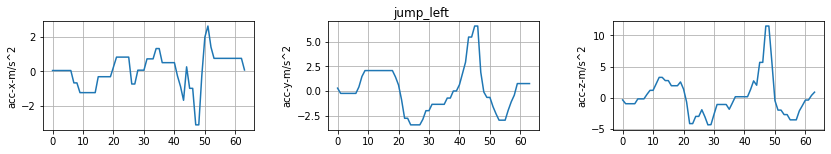

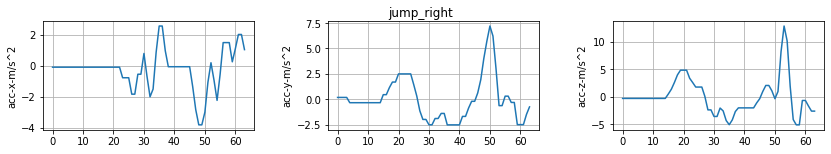

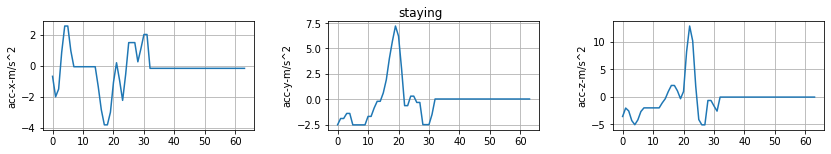

In [86]:
plot_data_from_row(df, 0, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], SRC_LABEL_COL)
plot_data_from_row(df, 1, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], SRC_LABEL_COL)
plot_data_from_row(df, 2, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], SRC_LABEL_COL)

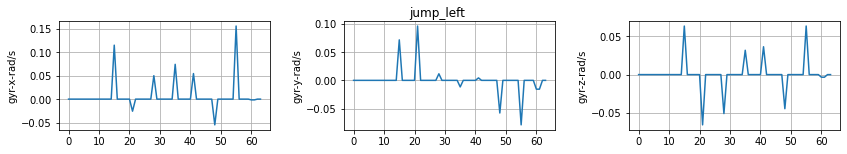

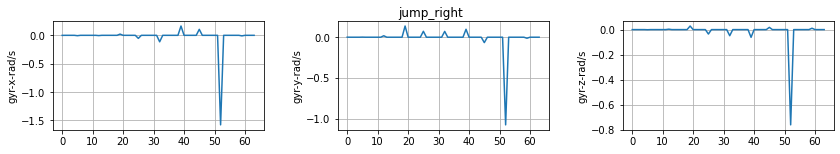

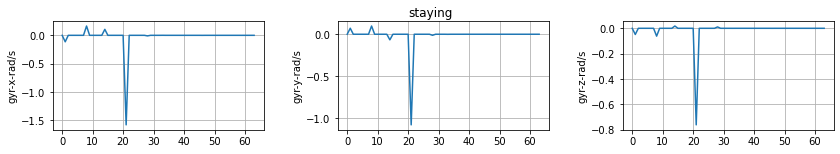

In [87]:
plot_data_from_row(df, 0, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], SRC_LABEL_COL)
plot_data_from_row(df, 1, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], SRC_LABEL_COL)
plot_data_from_row(df, 2, ['gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s'], SRC_LABEL_COL)

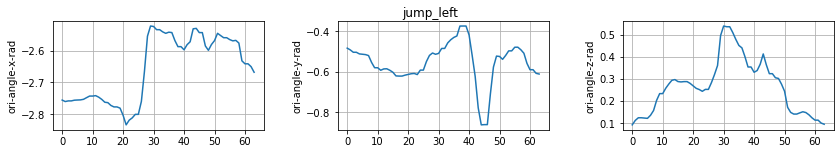

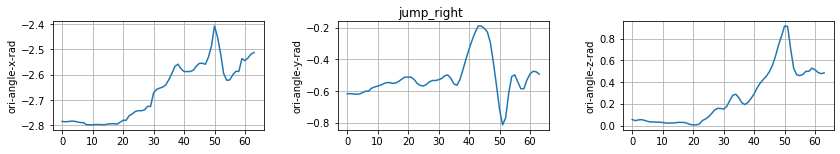

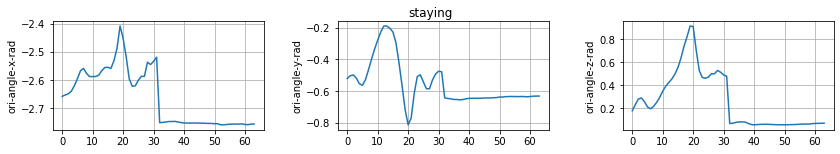

In [88]:
plot_data_from_row(df, 0, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], SRC_LABEL_COL)
plot_data_from_row(df, 1, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], SRC_LABEL_COL)
plot_data_from_row(df, 2, ['ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'], SRC_LABEL_COL)

# Clean

In [89]:
def evaluate_outliers(dataFrame, features, numRows, numCols, figsize=None):
    if (figsize is None):
        figsize=(14, 6)
    
    fig, axes = plt.subplots(numRows, numCols, figsize=figsize)

    for column, ax in zip(features, axes.flatten()):
        sn.boxplot(x= column, data=df_remove_outliers, ax=ax)

    plt.tight_layout()

## Accelerometer - Outliers

In [90]:
if (EVALUATE_OUTLIERS == True):
    
    df_remove_outliers = df.copy()
    
    accRawFeatures = [
        'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var', 'acc-x-std',
        'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var', 'acc-y-std',
        'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var', 'acc-z-std',
    ]
        
    evaluate_outliers(df_remove_outliers, accRawFeatures, 3, 5)

In [91]:
if (EVALUATE_OUTLIERS == True):
    
    #remove outliers
    # An outlier of a dataset is defined as a value that is more than 3 standard deviations from the mean
    for curFeature in accRawFeatures:
        df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers[curFeature])) < 3]
    
    evaluate_outliers(df_remove_outliers, accRawFeatures, 3, 5)

## Gyroscope - Outliers

In [92]:
if (EVALUATE_OUTLIERS == True):

    gyrFeatures = [
        'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var', 'gyr-x-std',
        'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var', 'gyr-y-std',
        'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var', 'gyr-z-std',
    ]
    
    evaluate_outliers(df_remove_outliers, gyrFeatures, 3, 5)

In [93]:
if (EVALUATE_OUTLIERS == True):

    for curFeature in gyrFeatures:
        df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers[curFeature])) < 3]
        
    evaluate_outliers(df_remove_outliers, gyrFeatures, 3, 5)

## Magnetometer - Outliers

In [94]:
if (EVALUATE_OUTLIERS == True):

    magFeatures = [
        'ori-angle-x-min', 'ori-angle-x-mean', 'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
        'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max', 'ori-angle-y-var', 'ori-angle-y-std',
        'ori-angle-z-min', 'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var', 'ori-angle-z-std',
    ]
    
    evaluate_outliers(df_remove_outliers, magFeatures, 3, 5)

In [95]:
if (EVALUATE_OUTLIERS == True):

    for curFeature in magFeatures:
        df_remove_outliers = df_remove_outliers[np.abs(zscore(df_remove_outliers[curFeature])) < 3]

    evaluate_outliers(df_remove_outliers, magFeatures, 3, 5)

In [96]:
if (CLEAN_OUTLIERS == True):

    # re-index
    df_remove_outliers = df_remove_outliers.reset_index(drop=True)

    #apply outliers
    df = df_remove_outliers
    del df_remove_outliers

In [97]:
# remove date cols
df.drop('startDate', inplace=True, axis=1)
df.drop('endDate', inplace=True, axis=1)

# remove sensor accuracy cols
df.drop('acc-accuracy', inplace=True, axis=1)
df.drop('gyr-accuracy', inplace=True, axis=1)
df.drop('mag-accuracy', inplace=True, axis=1)

# remove device-id col
df.drop('device-id', inplace=True, axis=1)

# Apply Filters

In [98]:
def medfilt (array, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert array.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (array), k), dtype=array.dtype)
    y[:,k2] = array
    
    for i in range (k2):
        j = k2 - i
        y[j:,i] = array[:-j]
        y[:j,i] = array[0]
        y[:-j,-(i+1)] = array[j:]
        y[-j:,-(i+1)] = array[-1]
        
    return np.median (y, axis=1)

def meanfilt (array, k):
    """Apply a length-k mean filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """

    assert k % 2 == 1, "Mean filter length must be odd."
    assert array.ndim == 1, "Input must be one-dimensional."
    
    k2 = (k - 1) // 2
    y = np.zeros ((len (array), k), dtype=array.dtype)
    y[:,k2] = array
    for i in range (k2):
        j = k2 - i
        y[j:,i] = array[:-j]
        y[:j,i] = array[0]
        y[:-j,-(i+1)] = array[j:]
        y[-j:,-(i+1)] = array[-1]
    return np.mean (y, axis=1)

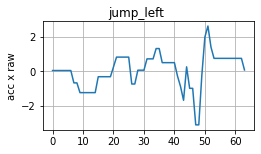

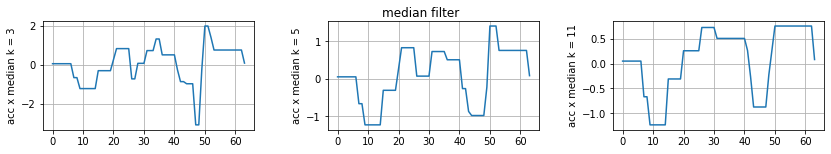

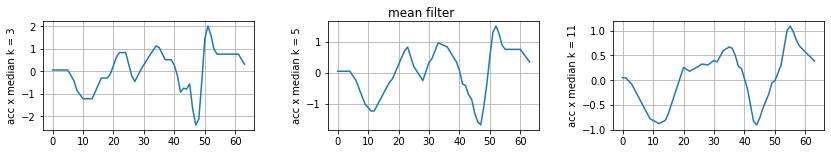

In [99]:
if (EVALUATE_FILTERS == True):

    raw_index = 0
    raw_data = df.at[raw_index, 'acc-x-m/s^2'];
    raw_label = df.at[raw_index, SRC_LABEL_COL];

    plot_data([
        None,
        { 'data': raw_data, 'name': 'acc x raw' }
    ], raw_label)

    plot_data([
        { 'data': medfilt(raw_data, 3), 'name': 'acc x median k = 3' },
        { 'data': medfilt(raw_data, 5), 'name': 'acc x median k = 5' },
        { 'data': medfilt(raw_data, 11), 'name': 'acc x median k = 11' }
    ], 'median filter');

    plot_data([
        { 'data': meanfilt(raw_data, 3), 'name': 'acc x median k = 3' },
        { 'data': meanfilt(raw_data, 5), 'name': 'acc x median k = 5' },
        { 'data': meanfilt(raw_data, 11), 'name': 'acc x median k = 11' }
    ], 'mean filter');

    del raw_data
    del raw_label

In [100]:
if (APPLY_FILTERS == True):

    df_filter = df.copy()

    #filter_type = 'median'
    filter_type = 'mean'
    
    k = 3 # try with 5 and 11
    
    featuresToFilter = [
        'acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2',
        'gyr-x-rad/s', 'gyr-y-rad/s', 'gyr-z-rad/s',
        'ori-angle-x-rad', 'ori-angle-y-rad', 'ori-angle-z-rad'
    ]

    if filter_type == 'median':
        for index, row in df_filter.iterrows():
            for curFeature in featuresToFilter:
                df_filter.at[index, curFeature] = medfilt(df_filter.at[index, curFeature], k)

    elif filter_type == 'mean':
        for index, row in df_filter.iterrows():
            for curFeature in featuresToFilter:
                df_filter.at[index, curFeature] = medfilt(df_filter.at[index, curFeature], k)

In [101]:
if (APPLY_FILTERS == True):
    
    df = df_filter
    del df_filter

# Enrichment

In [102]:
# root mean square = sqrt(x^2 + y^2 + z^2)
def rms(xArray, yArray, zArray):
    svmag_array = np.square([xArray, yArray, zArray])
    svmag_array = np.sum(svmag_array, axis=0)
    svmag_array = np.sqrt(svmag_array)
    return svmag_array

# signal magnitude area = sum(abs(x) + abs(y) + abs(z)) / arraySize
def sma(xArray, yArray, zArray):
    arraySize = len(xArray)
    result = np.abs([xArray, yArray, zArray])
    result = np.sum(result)
    return result / arraySize

# pearson correlation coefficient = cov(A, B) / (std(A) * std(B))
def pcorr(arrayA, arrayB):
    corr_matrix = np.corrcoef(arrayA, arrayB)
    corr = corr_matrix[0][1]
    
    if np.isnan(corr):
        return 0
    else:
        return corr
    
# difference between max and min positions
def min_max_diff(array):
    maxIndex = np.argmax(array, axis=0)
    minIndex = np.argmin(array, axis=0)
    return maxIndex - minIndex

# amplitude range = max - min
def amprange(array):
    return np.max(array) - np.min(array)

# average of array quarter
def mean_of_quarter(array, fromIndex, toIndex):
    array = array[fromIndex:toIndex]
    return np.mean(array)

# average peak-trough distance
def aptd(array):
    peakValue = array[0]
    troughValue = array[0]
    prevSlope = 0
    curSlope = 0
    sum = 0
    arraySize = len(array)
    evaluateSize = arraySize + 1
    
    for i in range(evaluateSize):
        if i == 0:
            curValue = array[i]
            continue
        
        prevValue = curValue
        prevSlope = curSlope
        
        if i < arraySize:
            curValue = array[i]
            curSlope = curValue - prevValue
        else:
            curSlope = prevSlope * -1
        
        # peak found
        if prevSlope > 0 and curSlope <= 0:
            peakValue = prevValue
            sum += peakValue - troughValue
            #print(f'=== peak found ({troughValue} to {peakValue})')
        # trough found
        elif prevSlope < 0 and curSlope >= 0:
            troughValue = prevValue
            sum += troughValue - peakValue
            #print(f'=== trough found ({peakValue} to {troughValue})')
            
    return sum / arraySize

def mean_absolute_deviation(array):
    mad = 0;

    if (len(array) > 0):
        mean = np.mean(array);
        
        for i in range(len(array)):
            mad += np.absolute(array[i] - mean);

        mad = np.sqrt(mad / len(array));
        
    return mad;

def median_absolute_deviation(array):
    return np.median(np.absolute(array - np.median(array)))

def fft(array):
    #print(array)
    dft1 = np.fft.fft(array)

    dft1_real = np.real( dft1 )
    #print(dft1_real)
    dft1_imag = np.imag( dft1 )
    #print(dft1_imag)

    magFft = []

    for i in range(len(dft1_real)):
        magFft.append(np.sqrt(np.square(dft1_real[i]) + np.square(dft1_imag[i])))
    
    return magFft

def energy(magFftArray):
    energy = 0
    
    for i in range(len(magFftArray)):
        energy = energy + np.square(magFftArray[i])
    
    if len(magFftArray) > 0:
        energy = energy / len(magFftArray)
    
    return energy

def entropy(magFftArray):
    entropy = 0
    psd = []
    
    if len(magFftArray) > 0:
        for i in range(len(magFftArray)):
            psd.append(np.square(magFftArray[i]) / len(magFftArray))
    
        psdSum = np.sum(psd)
        
        if psdSum > 0:
            for i in range(len(magFftArray)):
                psd[i] = psd[i] / psdSum
                
            for i in range(len(magFftArray)):
                if psd[i] != 0:
                    entropy = entropy + (psd[i] * np.log(psd[i]))
    
            entropy = entropy * -1
    
    return entropy

def calc_kurtosis(array):
    return kurtosis(array, fisher=False)

In [103]:
newFeatures = [
    # accelerometer
    {
        'name': 'acc-rms', 'dtype': object,
        'func': (lambda row: rms(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["acc-x-m/s^2"], row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-y-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-x-m/s^2"], row["acc-z-m/s^2"]))
    },
    { 
        'name': 'acc-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["acc-y-m/s^2"], row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-min-max-diff', 'dtype': np.float64,
        'func': (lambda row: min_max_diff(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-amprange', 'dtype': np.float64,
        'func': (lambda row: amprange(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-x-mean-1quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 0, 16))
    },
    {
        'name': 'acc-x-mean-2quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 16, 32))
    },
    {
        'name': 'acc-x-mean-3quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 32, 48))
    },
    {
        'name': 'acc-x-mean-4quarter', 'dtype': np.float64,
        'func': (lambda row: mean_of_quarter(row["acc-x-m/s^2"], 48, 64))
    },
    {
        'name': 'acc-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-rms"]))
    },
    {
        'name': 'acc-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["acc-z-m/s^2"]))
    },
    {
        'name': 'acc-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-fft"]))
    },
    {
        'name': 'acc-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-x-fft"]))
    },
    {
        'name': 'acc-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-y-fft"]))
    },
    {
        'name': 'acc-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["acc-z-fft"]))
    },
    {
        'name': 'acc-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-fft"]))
    },
    {
        'name': 'acc-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-x-fft"]))
    },
    {
        'name': 'acc-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-y-fft"]))
    },
    {
        'name': 'acc-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["acc-z-fft"]))
    },
    {
        'name': 'acc-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-rms"]))
    },
    {
        'name': 'acc-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-x-m/s^2"]))
    },
    {
        'name': 'acc-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-y-m/s^2"]))
    },
    {
        'name': 'acc-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["acc-z-m/s^2"]))
    },
    # gyroscope
    {
        'name': 'gyr-rms', 'dtype': object,
        'func': (lambda row: rms(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["gyr-x-rad/s"], row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-y-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-x-rad/s"], row["gyr-z-rad/s"]))
    },
    { 
        'name': 'gyr-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["gyr-y-rad/s"], row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-aptd', 'dtype': np.float64,
        'func': (lambda row: aptd(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-x-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-mad', 'dtype': np.float64,
        'func': (lambda row: median_absolute_deviation(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-rms"]))
    },
    {
        'name': 'gyr-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["gyr-z-rad/s"]))
    },
    {
        'name': 'gyr-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-fft"]))
    },
    {
        'name': 'gyr-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-x-fft"]))
    },
    {
        'name': 'gyr-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-y-fft"]))
    },
    {
        'name': 'gyr-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["gyr-z-fft"]))
    },
    {
        'name': 'gyr-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-fft"]))
    },
    {
        'name': 'gyr-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-x-fft"]))
    },
    {
        'name': 'gyr-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-y-fft"]))
    },
    {
        'name': 'gyr-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["gyr-z-fft"]))
    },
    {
        'name': 'gyr-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-rms"]))
    },
    {
        'name': 'gyr-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-x-rad/s"]))
    },
    {
        'name': 'gyr-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-y-rad/s"]))
    },
    {
        'name': 'gyr-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["gyr-z-rad/s"]))
    },
    # magnetometer
    {
        'name': 'mag-rms', 'dtype': object,
        'func': (lambda row: rms(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-sma', 'dtype': np.float64,
        'func': (lambda row: sma(row["ori-angle-x-rad"], row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-xy', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-y-rad"]))
    },
    { 
        'name': 'mag-pcorr-xz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-x-rad"], row["ori-angle-z-rad"]))
    },
    { 
        'name': 'mag-pcorr-yz', 'dtype': np.float64,
        'func': (lambda row: pcorr(row["ori-angle-y-rad"], row["ori-angle-z-rad"]))
    },
    {
        'name': 'mag-fft', 'dtype': object,
        'func': (lambda row: fft(row["mag-rms"]))
    },
    {
        'name': 'mag-x-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-x-rad"]))
    },
    {
        'name': 'mag-y-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-y-rad"]))
    },
    {
        'name': 'mag-z-fft', 'dtype': object,
        'func': (lambda row: fft(row["ori-angle-z-rad"]))
    },
    {
        'name': 'mag-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-fft"]))
    },
    {
        'name': 'mag-x-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-x-fft"]))
    },
    {
        'name': 'mag-y-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-y-fft"]))
    },
    {
        'name': 'mag-z-energy', 'dtype': np.float64,
        'func': (lambda row: energy(row["mag-z-fft"]))
    },
    {
        'name': 'mag-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-fft"]))
    },
    {
        'name': 'mag-x-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-x-fft"]))
    },
    {
        'name': 'mag-y-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-y-fft"]))
    },
    {
        'name': 'mag-z-entropy', 'dtype': np.float64,
        'func': (lambda row: entropy(row["mag-z-fft"]))
    },
     {
        'name': 'mag-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["mag-rms"]))
    },
    {
        'name': 'mag-x-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-x-rad"]))
    },
    {
        'name': 'mag-y-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-y-rad"]))
    },
    {
        'name': 'mag-z-kurtosis', 'dtype': np.float64,
        'func': (lambda row: calc_kurtosis(row["ori-angle-z-rad"]))
    },
    # activity label
    {
        'name': 'lateral-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT or row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'fake-move', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == FAKE_JUMP_LEFT or row[LABEL_COL] == FAKE_JUMP_RIGHT)
    },
    {
        'name': 'jump-left', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_LEFT)
    },
    {
        'name': 'jump-right', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] == JUMP_RIGHT)
    },
    {
        'name': 'staying', 'dtype': np.bool,
        'func': (lambda row: row[LABEL_COL] != JUMP_LEFT and row[LABEL_COL] != JUMP_RIGHT)
    }
    
    #TODO: add the folllowing
    # normalized energy
    
    #Maximum Peaks:
    #• Mean
    #• Median
    #• Standard Deviation
    #• Variance
    #• Five Largest Distances of Maximum Peaks
]

print("added new features")

# add new features
for newFeature in newFeatures:
    # add new column
    df[newFeature['name']] = pd.Series(df[LABEL_COL].apply(lambda x: 0), dtype=newFeature['dtype'])

    # fill new column
    for rowIndex, row in df.iterrows():
        df.at[rowIndex, newFeature['name']] = newFeature['func'](row);
        
        if (rowIndex == 0):
            print(newFeature['name'] + ": " + str(df.at[rowIndex, newFeature['name']]))

added new features
acc-rms: [ 0.45240883  0.99939426  0.99939426  0.99939426  0.99939426  0.31950775
  0.31950775  0.80102453  1.69392604  2.67384755  2.67384755  3.26337035
  4.04976048  4.04976048  3.64853477  3.44849511  2.83372395  2.83372395
  2.83372395  2.91517894  1.53021918  1.3971815   5.06688668  5.06688668
  4.63949967  4.63949967  4.01324607  4.65479463  5.22124277  4.76940971
  3.33726441  1.88680668  1.88680668  1.88680668  2.18701602  2.65591135
  1.24091182  0.89912205  0.52858967  0.52858967  0.81745668  1.78381716
  3.31109086  6.31031135  5.81543856  8.73673688  8.73673688 12.07002408
 11.92231991  5.72584734  2.14570398  3.65742497  3.36240132  4.08813318
  4.08813318  4.69115998  4.13276902  3.79956856  2.29000531  1.65000346
  1.12050632  1.12050632  1.11875138  1.1612659 ]
acc-sma: 4.7844445618750004
acc-pcorr-xy: -0.5233921900079217


C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DavidCraveiro\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


acc-pcorr-xz: -0.7416859885092927
acc-pcorr-yz: 0.6804506145293179
acc-x-min-max-diff: 4.0
acc-x-amprange: 5.7237401000000006
acc-x-mean-1quarter: -0.54257322375
acc-x-mean-2quarter: 0.16376235687499996
acc-x-mean-3quarter: -0.061862422499999986
acc-x-mean-4quarter: 0.6449590387499999
acc-x-aptd: -0.022545208749999997
acc-y-aptd: 0.108696806953125
acc-z-aptd: -0.2194088065625
acc-x-mad: 0.68511855
acc-y-mad: 1.69103005
acc-z-mad: 1.6534860500000002
acc-fft: [204.50072321355987, 39.395931903781715, 63.32155999861167, 41.326687495765114, 39.76269987980728, 15.423975330024582, 34.51931227963974, 21.122077654146135, 11.799281644676483, 7.668256059387544, 17.527070618509164, 12.473315110312944, 0.4011944314210266, 17.742603301419315, 7.069638921384786, 10.279017300847697, 7.482933410435735, 4.778087372233208, 7.0449899139327234, 4.399869322858753, 7.946084839120128, 1.5873454744242343, 6.289288195286296, 4.256967159730043, 4.534699046752186, 7.962264729189834, 2.2343690777579033, 2.47165401

gyr-y-fft: [0.0044820182999999875, 0.31222226797292596, 0.07923325715925374, 0.14517117182900613, 0.04761270462128322, 0.028429877230266132, 0.07194909562496031, 0.12861835939017283, 0.1185209188308333, 0.23765521939396125, 0.21681045792753761, 0.2057255942016248, 0.2156314972243423, 0.06714256089548697, 0.09654970352601983, 0.12383275573242937, 0.12008434449831386, 0.04412756299576983, 0.20582301011401316, 0.03335954632470161, 0.287312116259839, 0.07355588609356202, 0.2050581290190685, 0.14494294506373548, 0.05690985764103329, 0.20479511022085625, 0.07731276293300791, 0.13824922793959127, 0.14775834676430397, 0.1557669446454288, 0.18656290392129268, 0.16769969382737857, 0.1274143003, 0.16769969382737857, 0.18656290392129268, 0.1557669446454288, 0.14775834676430397, 0.13824922793959124, 0.07731276293300791, 0.20479511022085625, 0.05690985764103329, 0.1449429450637355, 0.2050581290190685, 0.073555886093562, 0.287312116259839, 0.033359546324701624, 0.20582301011401316, 0.0441275629957698

mag-energy: 478.12351740341074
mag-x-energy: 452.20068413551513
mag-y-energy: 20.399213316885234
mag-z-energy: 5.523619951010628
mag-entropy: 0.012069788831577858
mag-x-entropy: 0.013791474749598683
mag-y-entropy: 0.22336356136538696
mag-z-entropy: 0.7386277068463062
mag-kurtosis: 1.4971594633909175
mag-x-kurtosis: 1.3491770811081674
mag-y-kurtosis: 5.233109629130192
mag-z-kurtosis: 2.4931210103974126
lateral-move: True
fake-move: False
jump-left: True
jump-right: False
staying: False


# Describe

In [104]:
print(f'Rows: {df.shape[0]} | Cols: {df.shape[1]}')
df.describe()

Rows: 980 | Cols: 143


,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,acc-x-std,acc-y-min,acc-y-mean,acc-y-max,acc-y-var,acc-y-std,...,mag-y-energy,mag-z-energy,mag-entropy,mag-x-entropy,mag-y-entropy,mag-z-entropy,mag-kurtosis,mag-x-kurtosis,mag-y-kurtosis,mag-z-kurtosis
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,...,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,-2.239188,0.005383,2.122276,0.864270,0.830646,-3.955809,0.036625,5.438922,6.272134,2.006432,...,41.962718,10.139524,0.230252,1.173542,0.379808,2.007903,7.423148,8.383026,5.907982,6.415215
std,1.454740,0.135147,1.345900,0.769340,0.417701,3.084054,0.178396,4.115562,6.483029,1.499552,...,27.642990,15.845139,0.392477,1.087946,0.450463,0.812606,10.113843,11.868605,7.646803,9.555867
min,-9.082262,-0.504805,-0.364124,0.000000,0.000000,-11.548047,-0.620636,-0.264472,0.000000,0.000000,...,2.138823,0.005755,0.000028,0.000034,0.000302,0.013567,1.029255,1.015081,1.004287,1.042887
25%,-3.127152,-0.065913,1.059788,0.252689,0.502682,-6.531468,-0.065252,0.856241,0.144299,0.379866,...,23.754569,1.509921,0.009555,0.021465,0.051660,1.484562,2.434392,2.603837,2.782232,2.445620
50%,-2.085866,0.008504,1.955304,0.720713,0.848947,-3.664514,0.003255,6.160893,4.734146,2.175809,...,35.384752,3.312940,0.030152,1.177984,0.212522,2.048125,3.775204,4.192211,4.533229,3.724431
75%,-1.064446,0.078101,2.958642,1.269281,1.126624,-0.845350,0.097773,8.908779,10.684005,3.268640,...,46.443644,10.071171,0.305867,2.089940,0.574678,2.523352,7.819766,7.901271,6.048806,5.895048
max,0.246406,0.566052,7.695807,4.872267,2.207321,0.211476,0.748180,15.923394,26.315008,5.129816,...,125.068400,91.080827,2.366415,3.869428,2.589638,4.085941,60.903921,61.967217,60.191539,61.327190


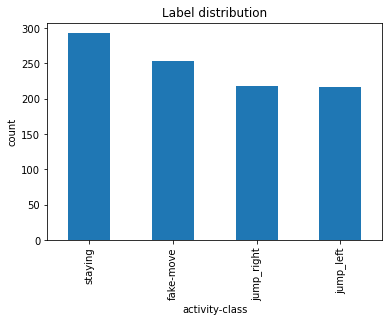

In [105]:
df[OUT_LABEL_COL].value_counts().plot.bar(title='Label distribution')
plt.ylabel('count')
plt.xlabel(OUT_LABEL_COL)
plt.show()

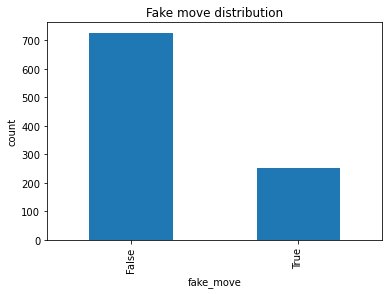

In [106]:
df['fake-move'].value_counts().plot.bar(title='Fake move distribution')
plt.ylabel('count')
plt.xlabel('fake_move')
plt.show()

In [107]:
MIN_NEG_CORR = -0.3
MIN_POS_CORR = 0.3

In [108]:
scaled_df = df.copy()

def drop_array_features(dataframe):
    # remove original array features
    for curFeature in arrayFeatures:
        dataframe.drop(curFeature, inplace=True, axis=1)

    # remove extracted array features
    dataframe.drop('acc-rms', inplace=True, axis=1)
    dataframe.drop('gyr-rms', inplace=True, axis=1)
    dataframe.drop('mag-rms', inplace=True, axis=1)
    dataframe.drop('acc-fft', inplace=True, axis=1)
    dataframe.drop('acc-x-fft', inplace=True, axis=1)
    dataframe.drop('acc-y-fft', inplace=True, axis=1)
    dataframe.drop('acc-z-fft', inplace=True, axis=1)
    dataframe.drop('gyr-fft', inplace=True, axis=1)
    dataframe.drop('gyr-x-fft', inplace=True, axis=1)
    dataframe.drop('gyr-y-fft', inplace=True, axis=1)
    dataframe.drop('gyr-z-fft', inplace=True, axis=1)
    dataframe.drop('mag-fft', inplace=True, axis=1)
    dataframe.drop('mag-x-fft', inplace=True, axis=1)
    dataframe.drop('mag-y-fft', inplace=True, axis=1)
    dataframe.drop('mag-z-fft', inplace=True, axis=1)
    
drop_array_features(scaled_df)

In [109]:
# apply feature scaling
scaled_df.drop(SRC_LABEL_COL, inplace=True, axis=1)
scaled_df.drop(OUT_LABEL_COL, inplace=True, axis=1)

col_names = scaled_df.columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df))
scaled_df.columns = col_names

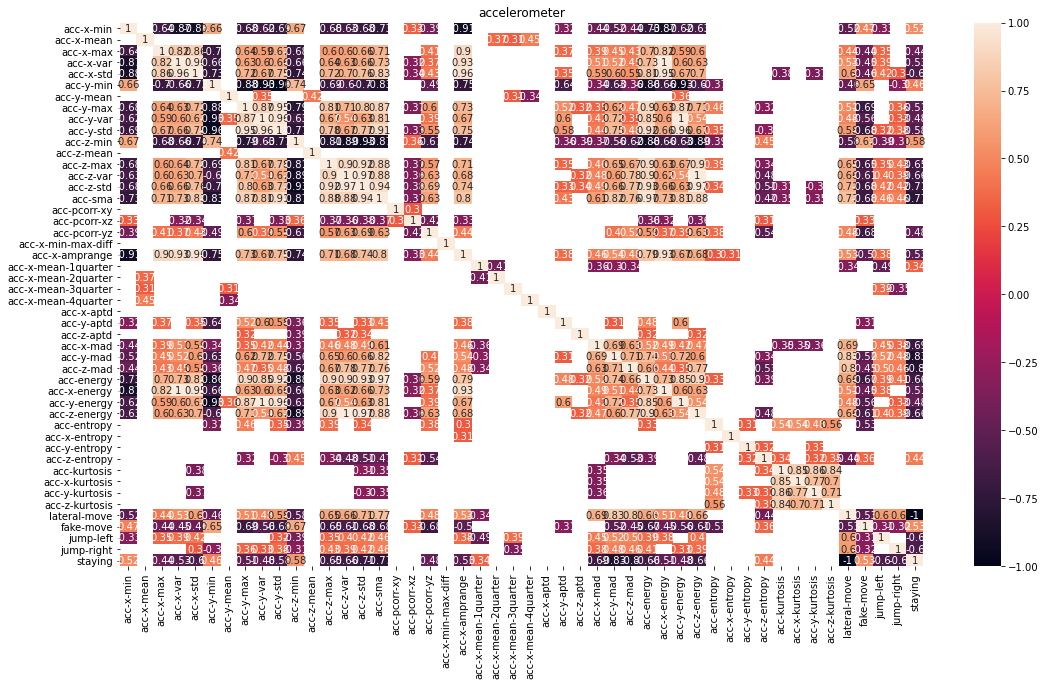

In [110]:
dfCorr = scaled_df[[
    'acc-x-min',
    'acc-x-mean',
    'acc-x-max',
    'acc-x-var',
    'acc-x-std',
    'acc-y-min',
    'acc-y-mean',
    'acc-y-max',
    'acc-y-var',
    'acc-y-std',
    'acc-z-min',
    'acc-z-mean',
    'acc-z-max',
    'acc-z-var',
    'acc-z-std',
    'acc-sma',
    'acc-pcorr-xy',
    'acc-pcorr-xz',
    'acc-pcorr-yz',
    'acc-x-min-max-diff',
    'acc-x-amprange',
    'acc-x-mean-1quarter',
    'acc-x-mean-2quarter',
    'acc-x-mean-3quarter',
    'acc-x-mean-4quarter',
    'acc-x-aptd',
    'acc-y-aptd',
    'acc-z-aptd',
    'acc-x-mad',
    'acc-y-mad',
    'acc-z-mad',
    'acc-energy',
    'acc-x-energy',
    'acc-y-energy',
    'acc-z-energy',
    'acc-entropy',
    'acc-x-entropy',
    'acc-y-entropy',
    'acc-z-entropy',
    'acc-kurtosis',
    'acc-x-kurtosis',
    'acc-y-kurtosis',
    'acc-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,10))
plt.title('accelerometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

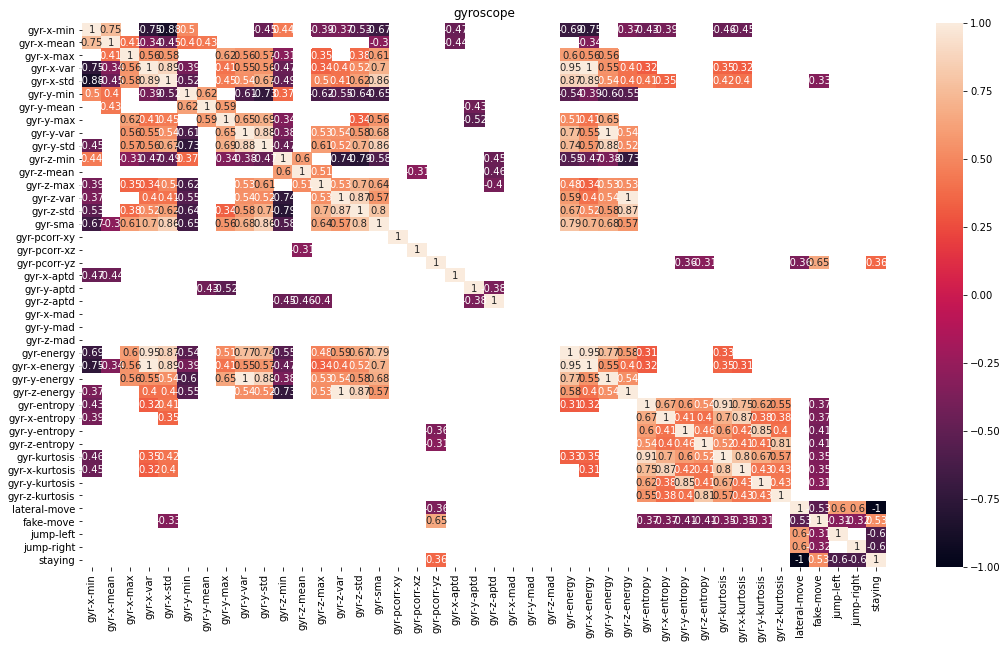

In [111]:
dfCorr = scaled_df[[
    'gyr-x-min',
    'gyr-x-mean',
    'gyr-x-max',
    'gyr-x-var',
    'gyr-x-std',
    'gyr-y-min',
    'gyr-y-mean',
    'gyr-y-max',
    'gyr-y-var',
    'gyr-y-std',
    'gyr-z-min',
    'gyr-z-mean',
    'gyr-z-max',
    'gyr-z-var',
    'gyr-z-std',
    'gyr-sma',
    'gyr-pcorr-xy',
    'gyr-pcorr-xz',
    'gyr-pcorr-yz',
    'gyr-x-aptd',
    'gyr-y-aptd',
    'gyr-z-aptd',
    'gyr-x-mad',
    'gyr-y-mad',
    'gyr-z-mad',
    'gyr-energy',
    'gyr-x-energy',
    'gyr-y-energy',
    'gyr-z-energy',
    'gyr-entropy',
    'gyr-x-entropy',
    'gyr-y-entropy',
    'gyr-z-entropy',
    'gyr-kurtosis',
    'gyr-x-kurtosis',
    'gyr-y-kurtosis',
    'gyr-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,10))
plt.title('gyroscope')
sn.heatmap(dfCorr, annot=True)
plt.show()

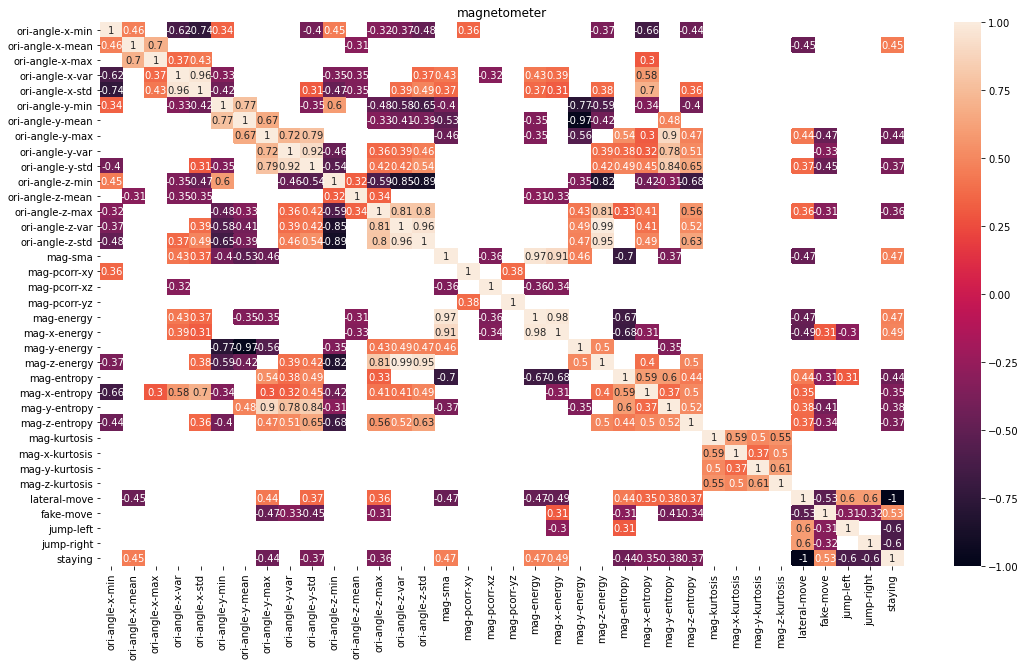

In [112]:
dfCorr = scaled_df[[
    'ori-angle-x-min',
    'ori-angle-x-mean',
    'ori-angle-x-max',
    'ori-angle-x-var',
    'ori-angle-x-std',
    'ori-angle-y-min',
    'ori-angle-y-mean',
    'ori-angle-y-max',
    'ori-angle-y-var',
    'ori-angle-y-std',
    'ori-angle-z-min',
    'ori-angle-z-mean',
    'ori-angle-z-max',
    'ori-angle-z-var',
    'ori-angle-z-std',
    'mag-sma',
    'mag-pcorr-xy',
    'mag-pcorr-xz',
    'mag-pcorr-yz',
    'mag-energy',
    'mag-x-energy',
    'mag-y-energy',
    'mag-z-energy',
    'mag-entropy',
    'mag-x-entropy',
    'mag-y-entropy',
    'mag-z-entropy',
    'mag-kurtosis',
    'mag-x-kurtosis',
    'mag-y-kurtosis',
    'mag-z-kurtosis',
    'lateral-move',
    'fake-move',
    'jump-left',
    'jump-right',
    'staying',
    #LABEL_COL
]].corr()

dfCorr = dfCorr[((dfCorr > MIN_POS_CORR) | (dfCorr < MIN_NEG_CORR))]

plt.figure(figsize=(18,10))
plt.title('magnetometer')
sn.heatmap(dfCorr, annot=True)
plt.show()

In [113]:
#move label column to the end
activityClassColumn = df.pop(OUT_LABEL_COL)
df[OUT_LABEL_COL] = activityClassColumn;

In [118]:
def drop_activity_label_features(dataFrame):
    dataFrame.drop(SRC_LABEL_COL, inplace=True, axis=1)
    dataFrame.drop(LABEL_COL, inplace=True, axis=1)
    dataFrame.drop('lateral-move', inplace=True, axis=1)
    dataFrame.drop('fake-move', inplace=True, axis=1)
    dataFrame.drop('jump-left', inplace=True, axis=1)
    dataFrame.drop('jump-right', inplace=True, axis=1)
    dataFrame.drop('staying', inplace=True, axis=1)

In [119]:
def drop_rms_based_FFT_features(dataFrame):
    # accelerometer
    dataFrame.drop('acc-energy', inplace=True, axis=1)
    dataFrame.drop('acc-entropy', inplace=True, axis=1)
    dataFrame.drop('acc-kurtosis', inplace=True, axis=1)
    
    # gyroscope
    dataFrame.drop('gyr-energy', inplace=True, axis=1)
    dataFrame.drop('gyr-entropy', inplace=True, axis=1)
    dataFrame.drop('gyr-kurtosis', inplace=True, axis=1)
    
    # magnetometer
    dataFrame.drop('mag-energy', inplace=True, axis=1)
    dataFrame.drop('mag-entropy', inplace=True, axis=1)
    dataFrame.drop('mag-kurtosis', inplace=True, axis=1)
    
def drop_axes_based_FFT_features(dataFrame):
    # accelerometer
    dataFrame.drop('acc-x-energy', inplace=True, axis=1)
    dataFrame.drop('acc-y-energy', inplace=True, axis=1)
    dataFrame.drop('acc-z-energy', inplace=True, axis=1)
    dataFrame.drop('acc-x-entropy', inplace=True, axis=1)
    dataFrame.drop('acc-y-entropy', inplace=True, axis=1)
    dataFrame.drop('acc-z-entropy', inplace=True, axis=1)
    dataFrame.drop('acc-x-kurtosis', inplace=True, axis=1)
    dataFrame.drop('acc-y-kurtosis', inplace=True, axis=1)
    dataFrame.drop('acc-z-kurtosis', inplace=True, axis=1)
    
    # gyroscope
    dataFrame.drop('gyr-x-energy', inplace=True, axis=1)
    dataFrame.drop('gyr-y-energy', inplace=True, axis=1)
    dataFrame.drop('gyr-z-energy', inplace=True, axis=1)
    dataFrame.drop('gyr-x-entropy', inplace=True, axis=1)
    dataFrame.drop('gyr-y-entropy', inplace=True, axis=1)
    dataFrame.drop('gyr-z-entropy', inplace=True, axis=1)
    dataFrame.drop('gyr-x-kurtosis', inplace=True, axis=1)
    dataFrame.drop('gyr-y-kurtosis', inplace=True, axis=1)
    dataFrame.drop('gyr-z-kurtosis', inplace=True, axis=1)
    
    # magnetometer
    dataFrame.drop('mag-x-energy', inplace=True, axis=1)
    dataFrame.drop('mag-y-energy', inplace=True, axis=1)
    dataFrame.drop('mag-z-energy', inplace=True, axis=1)
    dataFrame.drop('mag-x-entropy', inplace=True, axis=1)
    dataFrame.drop('mag-y-entropy', inplace=True, axis=1)
    dataFrame.drop('mag-z-entropy', inplace=True, axis=1)
    dataFrame.drop('mag-x-kurtosis', inplace=True, axis=1)
    dataFrame.drop('mag-y-kurtosis', inplace=True, axis=1)
    dataFrame.drop('mag-z-kurtosis', inplace=True, axis=1)
    
def drop_unnecessary_FFT_features(dataFrame):
    if (AXES_FFT_FEATURES == True):
        drop_rms_based_FFT_features(dataFrame)
    else:
        drop_axes_based_FFT_features(dataFrame);

In [120]:
def drop_irrelevante_features(dataFrame):
    # accelerometer
    dataFrame.drop('acc-x-aptd', inplace=True, axis=1)
    dataFrame.drop('acc-y-aptd', inplace=True, axis=1)
    dataFrame.drop('acc-z-aptd', inplace=True, axis=1)
    
    # gyroscope
    dataFrame.drop('gyr-x-aptd', inplace=True, axis=1)
    dataFrame.drop('gyr-y-aptd', inplace=True, axis=1)
    dataFrame.drop('gyr-z-aptd', inplace=True, axis=1)
    dataFrame.drop('gyr-x-mad', inplace=True, axis=1)
    dataFrame.drop('gyr-y-mad', inplace=True, axis=1)
    dataFrame.drop('gyr-z-mad', inplace=True, axis=1)
    
    # magnetometer
    #dataFrame.drop('mag-pcorr-xy', inplace=True, axis=1)
    #dataFrame.drop('mag-pcorr-xz', inplace=True, axis=1)
    #dataFrame.drop('mag-pcorr-zy', inplace=True, axis=1)

In [121]:
# export dataset
df_copy = df.copy()

drop_array_features(df_copy)
drop_activity_label_features(df_copy)
drop_unnecessary_FFT_features(df_copy)
drop_irrelevante_features(df_copy)

df_copy.to_csv(src_folder_path + '/dataset.csv', index=False, header=True, sep=",", decimal='.')